In [1]:
from datetime import datetime as dt 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(filepath_or_buffer='Building_Permits_Cleaned.csv', index_col=0)

In [3]:
lst = list(df[df.time_frame == 'unknown'].index)
df.drop(index=lst, inplace=True)

In [4]:
def to_category(columns, dataframe):
    """Convert a list of columns, from a dataframe, to a category datatype"""
    for column in columns: 
        dataframe[column] = dataframe[column].astype('category')

def to_integer(columns, dataframe):
    """Convert columns from a dataframe to an int64 datatype"""
    for column in columns: 
        dataframe[column] = dataframe[column].astype('int64')

In [5]:
cols = ['permit_type', 'description', 'current_status',
        'current_status_date', 'filed_date', 'issued_date', 'completed_date',
        'permit_expiration_date', 'revised_cost', 'proposed_use',
        'existing_use', 'plansets','tidf_compliance', 'existing_construction_type',
        'proposed_construction_type','site_permit', 
        'neighborhoods', 'zipcode', 'location','address', 'time_range', 'time_frame',
        'region', 'fire_only_permit', 'supervisor_district']
df.drop(columns=cols, inplace=True)

In [6]:
columns = ['permit_type_definition',
           'existing_construction_type_description',
           'proposed_construction_type_description',
           'decision', 'existing_use_category',
           'proposed_use_category']

to_category(columns=columns, dataframe=df)

Columns that need mean imputed: existing_stories, proposed_stories, estimated_cost, existing_units, proposed_units, latitude, longitude
Need to convert categories to code: permit_type_definition, existing_construction_type_description, proposed_construction_type_description, decision, region, existing_use_category, proposed_use_category

In [7]:
columns = ['permit_type_definition',
           'existing_construction_type_description',
           'proposed_construction_type_description',
           'existing_use_category',
           'proposed_use_category']
df = pd.get_dummies(data=df, columns=columns)

In [8]:
y = df.decision
X = df.drop(columns='decision')

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [10]:
imp = Imputer()
scaler = StandardScaler()
clf = LogisticRegression(multi_class='multinomial', solver='newton-cg')

pipeline = make_pipeline(imp, scaler)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
Xtrain_scaled = pipeline.fit_transform(Xtrain)
Xtest_scaled = pipeline.transform(Xtest)

In [12]:
param_grid = {'C':[0.001, 0.01, 0.1,1,10,50,75, 100, 150, 200]}

search = GridSearchCV(estimator=clf, param_grid=param_grid,
                      scoring='neg_log_loss', cv=5)

In [13]:
search.fit(Xtrain_scaled, ytrain)
search.best_params_

{'C': 100}

In [14]:
best_clf = LogisticRegression(C=100, multi_class='multinomial', solver='newton-cg')

In [15]:
best_clf.fit(Xtrain_scaled, ytrain)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
denied = best_clf.coef_[0]
instant = best_clf.coef_[1]
non_instant = best_clf.coef_[2]

In [19]:
lst = df.drop(columns='decision')
lst = list(lst.columns)

for feature in zip(lst, denied):
    print(feature)

('number_of_existing_stories', 0.04017247933668223)
('number_of_proposed_stories', -0.12823484986176176)
('estimated_cost', 7.446477063889653)
('existing_units', 0.03292814194970914)
('proposed_units', -0.01965875799697892)
('latitude', 0.015559703466062681)
('longitude', 0.05183970517324758)
('permit_type_definition_additions alterations or repairs', 0.3979192753950102)
('permit_type_definition_demolitions', 0.05118239592882571)
('permit_type_definition_grade or quarry or fill or excavate', -0.1390077973413566)
('permit_type_definition_new construction', 0.12064421638594001)
('permit_type_definition_new construction wood frame', 0.20581452894866323)
('permit_type_definition_otc alterations permit', -0.4318337957597119)
('permit_type_definition_sign - erect', 0.06327862766360479)
('permit_type_definition_wall or painted sign', 0.04810530814344404)
('existing_construction_type_description_constr type 1', -0.12438913326609113)
('existing_construction_type_description_constr type 2', -0.0

In [20]:
for feature in zip(lst, instant):
    print(feature)

('number_of_existing_stories', -0.008833919388696059)
('number_of_proposed_stories', 0.06141575276261681)
('estimated_cost', -15.552524788910436)
('existing_units', -0.04674679486340193)
('proposed_units', 0.048508237003758434)
('latitude', -0.03208969073994489)
('longitude', -0.044436187868262714)
('permit_type_definition_additions alterations or repairs', -0.6669597118789252)
('permit_type_definition_demolitions', -0.11481799483004863)
('permit_type_definition_grade or quarry or fill or excavate', 0.029595000051756)
('permit_type_definition_new construction', -0.1624820148125078)
('permit_type_definition_new construction wood frame', -0.355047413493956)
('permit_type_definition_otc alterations permit', 0.7580460242858786)
('permit_type_definition_sign - erect', -0.14831321036562098)
('permit_type_definition_wall or painted sign', -0.06480340395622129)
('existing_construction_type_description_constr type 1', 0.09190798517478428)
('existing_construction_type_description_constr type 2',

In [21]:
for feature in zip(lst, non_instant):
    print(feature)

('number_of_existing_stories', -0.03133855994578125)
('number_of_proposed_stories', 0.06681909710067609)
('estimated_cost', 8.10604772502946)
('existing_units', 0.013818652915949014)
('proposed_units', -0.028849479000742223)
('latitude', 0.01652998727332351)
('longitude', -0.0074035173031862436)
('permit_type_definition_additions alterations or repairs', 0.26904043648380127)
('permit_type_definition_demolitions', 0.06363559889988353)
('permit_type_definition_grade or quarry or fill or excavate', 0.10941279729064447)
('permit_type_definition_new construction', 0.04183779842265402)
('permit_type_definition_new construction wood frame', 0.14923288454700184)
('permit_type_definition_otc alterations permit', -0.3262122285225522)
('permit_type_definition_sign - erect', 0.08503458270403776)
('permit_type_definition_wall or painted sign', 0.016698095811641528)
('existing_construction_type_description_constr type 1', 0.03248114809181506)
('existing_construction_type_description_constr type 2', 

In [22]:
ypred = best_clf.predict(Xtest_scaled)

print("Training Accuracy: {}".format(best_clf.score(Xtrain_scaled, ytrain)))
print("Testing Accuracy: {}".format(best_clf.score(Xtest_scaled, ytest)))

Training Accuracy: 0.7341360886935037
Testing Accuracy: 0.7321899736147758


In [23]:
ypred_prob = best_clf.predict_proba(Xtest_scaled)

In [24]:
ytest = list(ytest)
ypred = list(ypred)
confusion_matrix = confusion_matrix(y_true=ytest, y_pred=ypred)

In [25]:
confusion_matrix

array([[    1,   495,   565],
       [    0, 34756,  2985],
       [    3, 12395, 10198]])

In [26]:
ytest = pd.Series(ytest)
ypred = pd.Series(ypred)
pd.crosstab(ytest, ypred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,denied,instant approval,non-instant approval,All
True,,,,
denied,1,495,565,1061
instant approval,0,34756,2985,37741
non-instant approval,3,12395,10198,22596
All,4,47646,13748,61398


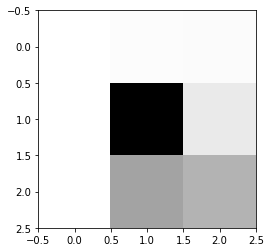

In [27]:
plt.imshow(confusion_matrix, cmap='binary', interpolation='None')
plt.show()

In [28]:
print(classification_report(ytest, ypred))

                      precision    recall  f1-score   support

              denied       0.25      0.00      0.00      1061
    instant approval       0.73      0.92      0.81     37741
non-instant approval       0.74      0.45      0.56     22596

         avg / total       0.73      0.73      0.71     61398



In [29]:
from sklearn.metrics import log_loss 

In [30]:
y = log_loss(y_true=ytest, y_pred=ypred_prob, labels=['denied', 'instant approval', 'non-instant approval'])
print(y)

0.5545201405325255


### Random Forest Classifier

In [31]:
rfc = RandomForestClassifier()

In [32]:
n_estimators = [int(x) for x in np.linspace(start = 25, stop = 700, num = 25)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
param = {'n_estimators':n_estimators, 
         'max_depth':max_depth,
         'min_samples_split':min_samples_split,
         'min_samples_leaf':min_samples_leaf}

In [33]:
imp = Imputer()
Xtrain = imp.fit_transform(Xtrain)
Xtest = imp.transform(Xtest)

In [36]:
rscv = RandomizedSearchCV(estimator=rfc, param_distributions=param,
                                 n_iter=20, scoring='neg_log_loss', cv=5)

rscv.fit(Xtrain, ytrain)
rscv.best_params_

KeyboardInterrupt: 

In [37]:
rfc = RandomForestClassifier(n_estimators=531, min_samples_split=2, min_samples_leaf=2, max_depth=60)
rfc.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=531, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
lst = df.drop(columns='decision')
lst = list(lst.columns)

In [39]:
for feature in zip(lst, rfc.feature_importances_):
    print(feature)

('number_of_existing_stories', 0.03234980817958308)
('number_of_proposed_stories', 0.035498422810271164)
('estimated_cost', 0.27860292312008994)
('existing_units', 0.03565973523013657)
('proposed_units', 0.03459789689491389)
('latitude', 0.11560411271492792)
('longitude', 0.11673038899117459)
('permit_type_definition_additions alterations or repairs', 0.04454058861401601)
('permit_type_definition_demolitions', 0.00036474337504237725)
('permit_type_definition_grade or quarry or fill or excavate', 0.0004967535282981925)
('permit_type_definition_new construction', 0.00012013187418003137)
('permit_type_definition_new construction wood frame', 0.0008081896345725755)
('permit_type_definition_otc alterations permit', 0.0810557738126027)
('permit_type_definition_sign - erect', 0.002955586044670701)
('permit_type_definition_wall or painted sign', 0.001284632384617109)
('existing_construction_type_description_constr type 1', 0.0026372874713499394)
('existing_construction_type_description_constr 

In [40]:
ypred = rfc.predict(Xtest)

In [41]:
print("Training Accuracy: {}".format(rfc.score(Xtrain, ytrain)))
print("Testing Accuracy: {}".format(rfc.score(Xtest, ytest)))

Training Accuracy: 0.8625154427455196
Testing Accuracy: 0.7849115606371543


In [42]:
print(classification_report(ytest, ypred))

                      precision    recall  f1-score   support

              denied       0.93      0.05      0.10      1061
    instant approval       0.79      0.90      0.84     37741
non-instant approval       0.77      0.63      0.69     22596

         avg / total       0.79      0.78      0.77     61398



In [43]:
ytest = pd.Series(ytest)
ypred = pd.Series(ypred)
pd.crosstab(ytest, ypred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,denied,instant approval,non-instant approval,All
True,,,,
denied,54,411,596,1061
instant approval,4,33989,3748,37741
non-instant approval,0,8447,14149,22596
All,58,42847,18493,61398


In [44]:
ypred_prob = rfc.predict_proba(Xtest)
y = log_loss(y_true=ytest, y_pred=ypred_prob, labels=['denied', 'instant approval', 'non-instant approval'])
print(y)

0.4865324008045104


### Random Forest With Feature Selection

In [45]:
sfm = SelectFromModel(estimator=rfc)
sfm.fit(Xtrain, ytrain)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=531, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        norm_order=1, prefit=False, threshold=None)

In [46]:
nw_lst = []
for feature_list_index in sfm.get_support(indices=True):
    print(lst[feature_list_index])
    nw_lst.append(lst[feature_list_index])

number_of_existing_stories
number_of_proposed_stories
estimated_cost
existing_units
proposed_units
latitude
longitude
permit_type_definition_additions alterations or repairs
permit_type_definition_otc alterations permit
existing_construction_type_description_unknown
proposed_construction_type_description_unknown
existing_use_category_unknown
proposed_use_category_unknown


In [47]:
X_important_train = sfm.transform(Xtrain)
X_important_test = sfm.transform(Xtest)

In [50]:
search = RandomizedSearchCV(estimator=rfc, param_distributions=param,
                                 n_iter=20, scoring='neg_log_loss', cv=5)

search.fit(X_important_train, ytrain)
search.best_params_

{'n_estimators': 671,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': 60}

In [51]:
rfc_important = RandomForestClassifier(n_estimators=671, min_samples_split=2, min_samples_leaf=2, max_depth=60)
rfc_important.fit(X_important_train, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=671, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [52]:
for feature in zip(nw_lst, rfc_important.feature_importances_):
    print(feature)f

('number_of_existing_stories', 0.02790341256983765)
('number_of_proposed_stories', 0.032251417615707434)
('estimated_cost', 0.28281322060346276)
('existing_units', 0.04064609961250231)
('proposed_units', 0.0404938732180952)
('latitude', 0.14861878964327935)
('longitude', 0.15078876131659946)
('permit_type_definition_additions alterations or repairs', 0.031261289704192556)
('permit_type_definition_otc alterations permit', 0.09151100020571167)
('existing_construction_type_description_unknown', 0.031164484242681596)
('proposed_construction_type_description_unknown', 0.03332071189942643)
('existing_use_category_unknown', 0.049042827667991465)
('proposed_use_category_unknown', 0.04018411170051215)


In [53]:
ypred = rfc_important.predict(X_important_test)

In [54]:
print("Training Accuracy: {}".format(rfc_important.score(X_important_train, ytrain)))
print("Testing Accuracy: {}".format(rfc_important.score(X_important_test, ytest)))

Training Accuracy: 0.8891652092993406
Testing Accuracy: 0.7851232939183687


In [55]:
print(classification_report(ytest, ypred))

                      precision    recall  f1-score   support

              denied       0.97      0.06      0.11      1061
    instant approval       0.80      0.90      0.84     37741
non-instant approval       0.76      0.63      0.69     22596

         avg / total       0.79      0.79      0.77     61398



In [56]:
ytest = pd.Series(ytest)
ypred = pd.Series(ypred)
pd.crosstab(ytest, ypred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,denied,instant approval,non-instant approval,All
True,,,,
denied,63,408,590,1061
instant approval,2,33851,3888,37741
non-instant approval,0,8305,14291,22596
All,65,42564,18769,61398


In [57]:
ypred_prob = rfc_important.predict_proba(X_important_test)
y = log_loss(y_true=ytest, y_pred=ypred_prob, labels=['denied', 'instant approval', 'non-instant approval'])
print(y)

0.4863659362575302


The most predictive features are estimated cost, latitude, longitude and whether it is permit type 8

In [63]:
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [64]:
sb.set()

In [67]:
df = pd.DataFrame(data={"features":nw_lst, "importance":rfc_important.feature_importances_})

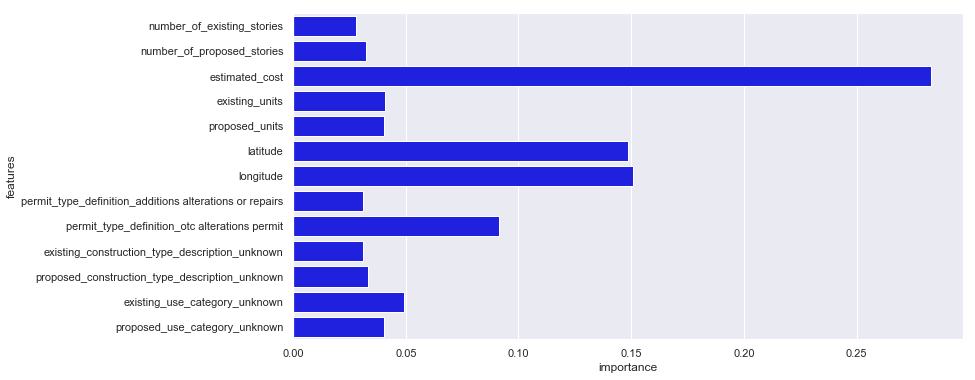

In [71]:
plt.figure(figsize=(12,6))
sb.barplot(x="importance", y="features", color="blue", data=df)

In [ ]:
s